In [1]:
import csv
import pandas as pd
import numpy as np

In [2]:
india_df= pd.read_csv('https://raw.githubusercontent.com/imdevskp/covid-19-india-data/master/complete.csv')

In [3]:
india_df.tail()

,Date,Name of State / UT,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated,New cases,New deaths,New recovered
4687,2020-08-06,Telangana,18.1124,79.0193,73050.0,589,52103.0,2092,0,1289
4688,2020-08-06,Tripura,23.9408,91.9882,5725.0,31,3793.0,97,0,68
4689,2020-08-06,Uttar Pradesh,26.8467,80.9462,104388.0,1857,60558.0,4078,0,3287
4690,2020-08-06,Uttarakhand,30.0668,79.0193,8254.0,98,5233.0,246,0,386
4691,2020-08-06,West Bengal,22.9868,87.8550,83800.0,1846,58962.0,2816,0,2078


In [4]:
india_df = india_df.rename(columns= {'Name of State / UT':'State', 'Total Confirmed cases': 'Confirmed', 'New cases':'New_cases' })
india_df

,Date,State,Latitude,Longitude,Confirmed,Death,Cured/Discharged/Migrated,New_cases,New deaths,New recovered
0,2020-01-30,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
1,2020-01-31,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
2,2020-02-01,Kerala,10.8505,76.2711,2.0,0,0.0,1,0,0
3,2020-02-02,Kerala,10.8505,76.2711,3.0,0,0.0,1,0,0
4,2020-02-03,Kerala,10.8505,76.2711,3.0,0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
4687,2020-08-06,Telangana,18.1124,79.0193,73050.0,589,52103.0,2092,0,1289
4688,2020-08-06,Tripura,23.9408,91.9882,5725.0,31,3793.0,97,0,68
4689,2020-08-06,Uttar Pradesh,26.8467,80.9462,104388.0,1857,60558.0,4078,0,3287
4690,2020-08-06,Uttarakhand,30.0668,79.0193,8254.0,98,5233.0,246,0,386


In [5]:
#State wise sum
india_cases = india_df.groupby('State').agg({'New_cases':np.sum})
india_deaths = india_df.groupby('State').agg({'New deaths' : np.sum})
india_recoveries = india_df.groupby('State').agg({'New recovered':np.sum})

In [6]:
india_overall = india_cases.copy()
india_overall['Deaths']= india_deaths
india_overall['Recovered']= india_recoveries
india_overall= india_overall.rename(columns={'New_cases': 'Confirmed Cases'})
india_overall.reset_index(inplace=True)

In [7]:
#Timeline
cases_over_time = india_df.groupby('Date').agg({'Confirmed': np.sum})
deaths_over_time = india_df.groupby('Date').agg({'Death': np.sum})
recoveries_over_time = india_df.groupby('Date').agg({'Cured/Discharged/Migrated': np.sum})

In [8]:
#Daily Cases
daily_cases = india_df.groupby('Date').agg({'New_cases': np.sum})
daily_deaths = india_df.groupby('Date').agg({'New deaths': np.sum})
daily_recovered= india_df.groupby('Date').agg({'New recovered': np.sum})

In [9]:
#State wise Daily Cases
state_daily_cases= india_df.pivot_table(values='Confirmed',index='Date',columns='State', aggfunc=np.sum)
state_daily_deaths= india_df.pivot_table(values='Death',index='Date',columns='State', aggfunc=np.sum)
state_daily_recoveries= india_df.pivot_table(values='Cured/Discharged/Migrated',index='Date',columns='State', aggfunc=np.sum)

In [10]:
#Top 5 States
top5_states_daily = state_daily_cases[['Maharashtra', 'Tamil Nadu', 'Delhi', 'Gujarat', 'Uttar Pradesh']]

In [11]:
#Overall State Table
india_overall= india_overall.sort_values(by='Confirmed Cases', ascending=False)
india_overall['Mortality Rate']= india_overall['Deaths']/ india_overall['Confirmed Cases']
india_overall['Recovery Rate'] = india_overall['Recovered']/ india_overall['Confirmed Cases']
india_overall.style.background_gradient(cmap='Reds')

,State,Confirmed Cases,Deaths,Recovered,Mortality Rate,Recovery Rate
19,Maharashtra,468267,0,305521,0.000000,0.652450
29,Tamil Nadu,273459,0,214815,0.000000,0.785547
1,Andhra Pradesh,186460,0,104354,0.000000,0.559659
15,Karnataka,151448,0,74679,0.000000,0.493100
8,Delhi,140231,0,126116,0.000000,0.899345
37,Uttar Pradesh,104382,0,60558,0.000000,0.580157
39,West Bengal,83799,0,58962,0.000000,0.703612
30,Telangana,68730,0,50110,0.000000,0.729085
10,Gujarat,66667,0,49433,0.000000,0.741491
4,Bihar,64768,0,42414,0.000000,0.654860


In [12]:
from fbprophet import Prophet
fb_df = cases_over_time.copy() 
fb_df.reset_index(inplace=True)

Importing plotly failed. Interactive plots will not work.


In [13]:
# Prophet requires columns ds (Date) and y (value)
fb_df = fb_df.rename(columns={'Date': 'ds', 'Confirmed': 'y'})
fb_df.head()

,ds,y
0,2020-01-30,1.0
1,2020-01-31,1.0
2,2020-02-01,2.0
3,2020-02-02,3.0
4,2020-02-03,3.0


In [14]:
# Make the prophet model and fit on the data
fb_prophet = Prophet(yearly_seasonality=False)
fb_prophet.fit(fb_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
# Python
future = fb_prophet.make_future_dataframe(periods=30)
future.tail()

,ds
211,2020-09-01
212,2020-09-02
213,2020-09-03
214,2020-09-04
215,2020-09-05


In [16]:
forecast = fb_prophet.predict(future)
forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
206,2020-08-27,2.439168e+06,2.365736e+06,2.512299e+06
207,2020-08-28,2.460517e+06,2.382132e+06,2.536021e+06
208,2020-08-29,2.499233e+06,2.421284e+06,2.578924e+06
209,2020-08-30,2.532566e+06,2.449948e+06,2.613106e+06
210,2020-08-31,2.565960e+06,2.483684e+06,2.648299e+06
211,2020-09-01,2.599673e+06,2.515990e+06,2.687361e+06
212,2020-09-02,2.633067e+06,2.539821e+06,2.722384e+06
213,2020-09-03,2.667595e+06,2.571203e+06,2.757498e+06
214,2020-09-04,2.688944e+06,2.586940e+06,2.781684e+06
215,2020-09-05,2.727660e+06,2.625273e+06,2.829530e+06


In [17]:
# 1 day Prediction
future_day = fb_prophet.make_future_dataframe(periods=1)
future_day.tail()

,ds
182,2020-08-03
183,2020-08-04
184,2020-08-05
185,2020-08-06
186,2020-08-07


In [18]:
forecast_day = fb_prophet.predict(future_day)
forecast_day[['ds','yhat', 'yhat_lower', 'yhat_upper']].tail(1)

,ds,yhat,yhat_lower,yhat_upper
186,2020-08-07,1.775235e+06,1.713934e+06,1.832310e+06


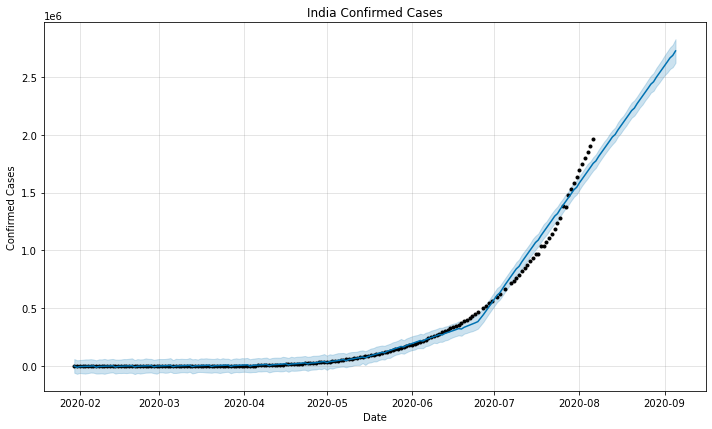

In [19]:
import matplotlib.pyplot as plt
fb_prophet.plot(forecast, xlabel = 'Date', ylabel = 'Confirmed Cases')
plt.title('India Confirmed Cases');

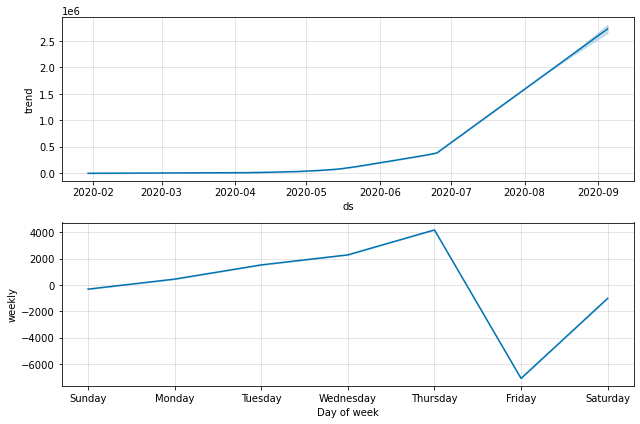

In [20]:
#Components
comp = fb_prophet.plot_components(forecast)